In [17]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [60]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

In [64]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

# Real-World Application to US Data

### Setup

Load US state case data from the NYT archive

In [39]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()
states

state    date      
Alabama  2020-03-13      6
         2020-03-14     12
         2020-03-15     23
         2020-03-16     29
         2020-03-17     39
                      ... 
Wyoming  2020-04-09    239
         2020-04-10    253
         2020-04-11    261
         2020-04-12    270
         2020-04-13    275
Name: cases, Length: 2329, dtype: int64

# Finland Data

In [80]:
# TODO: get data straight from THL?

finland = pd.read_csv('finland_stat.csv', sep='\t', 
                      skiprows=1, header=None, names = ['date', 'cases_in_day'],
                      parse_dates=['date'])
#finland.columns = ['date', 'cases_in_day']

# Calc cumulative cases
cumulative_cases_list = []
cases_total = 0
for index, row in finland.iterrows():
    cases_total += row['cases_in_day']
    cumulative_cases_list.append(cases_total)
cumulative_cases_list
finland['cases'] = cumulative_cases_list

# set index
finland.set_index(finland['date'], inplace=True)

finland

,date,cases_in_day,cases
date,,,
2020-02-25,2020-02-25,1,1
2020-02-26,2020-02-26,0,1
2020-02-27,2020-02-27,1,2
2020-02-28,2020-02-28,2,4
2020-02-29,2020-02-29,1,5
2020-03-01,2020-03-01,1,6
2020-03-02,2020-03-02,0,6
2020-03-03,2020-03-03,4,10
2020-03-04,2020-03-04,5,15


In [81]:
finland['cases']

date
2020-02-25       1
2020-02-26       1
2020-02-27       2
2020-02-28       4
2020-02-29       5
2020-03-01       6
2020-03-02       6
2020-03-03      10
2020-03-04      15
2020-03-05      16
2020-03-06      21
2020-03-07      28
2020-03-08      37
2020-03-09      53
2020-03-10     107
2020-03-11     182
2020-03-12     239
2020-03-13     267
2020-03-14     293
2020-03-15     340
2020-03-16     385
2020-03-17     426
2020-03-18     512
2020-03-19     604
2020-03-20     685
2020-03-21     767
2020-03-22     844
2020-03-23     926
2020-03-24    1024
2020-03-25    1123
2020-03-26    1228
2020-03-27    1318
2020-03-28    1389
2020-03-29    1448
2020-03-30    1562
2020-03-31    1674
2020-04-01    1796
2020-04-02    1931
2020-04-03    2111
2020-04-04    2179
2020-04-05    2279
2020-04-06    2450
2020-04-07    2643
2020-04-08    2770
2020-04-09    2916
2020-04-10    2977
2020-04-11    3044
2020-04-12    3119
2020-04-13    3202
2020-04-14    3239
Name: cases, dtype: int64

In [71]:
state_name = 'Finland'
finland['cases'].rename(f"{state_name} cases")

date
2020-02-25       1
2020-02-26       1
2020-02-27       2
2020-02-28       4
2020-02-29       5
2020-03-01       6
2020-03-02       6
2020-03-03      10
2020-03-04      15
2020-03-05      16
2020-03-06      21
2020-03-07      28
2020-03-08      37
2020-03-09      53
2020-03-10     107
2020-03-11     182
2020-03-12     239
2020-03-13     267
2020-03-14     293
2020-03-15     340
2020-03-16     385
2020-03-17     426
2020-03-18     512
2020-03-19     604
2020-03-20     685
2020-03-21     767
2020-03-22     844
2020-03-23     926
2020-03-24    1024
2020-03-25    1123
2020-03-26    1228
2020-03-27    1318
2020-03-28    1389
2020-03-29    1448
2020-03-30    1562
2020-03-31    1674
2020-04-01    1796
2020-04-02    1931
2020-04-03    2111
2020-04-04    2179
2020-04-05    2279
2020-04-06    2450
2020-04-07    2643
2020-04-08    2770
2020-04-09    2916
2020-04-10    2977
2020-04-11    3044
2020-04-12    3119
2020-04-13    3202
2020-04-14    3239
Name: Finland cases, dtype: int64

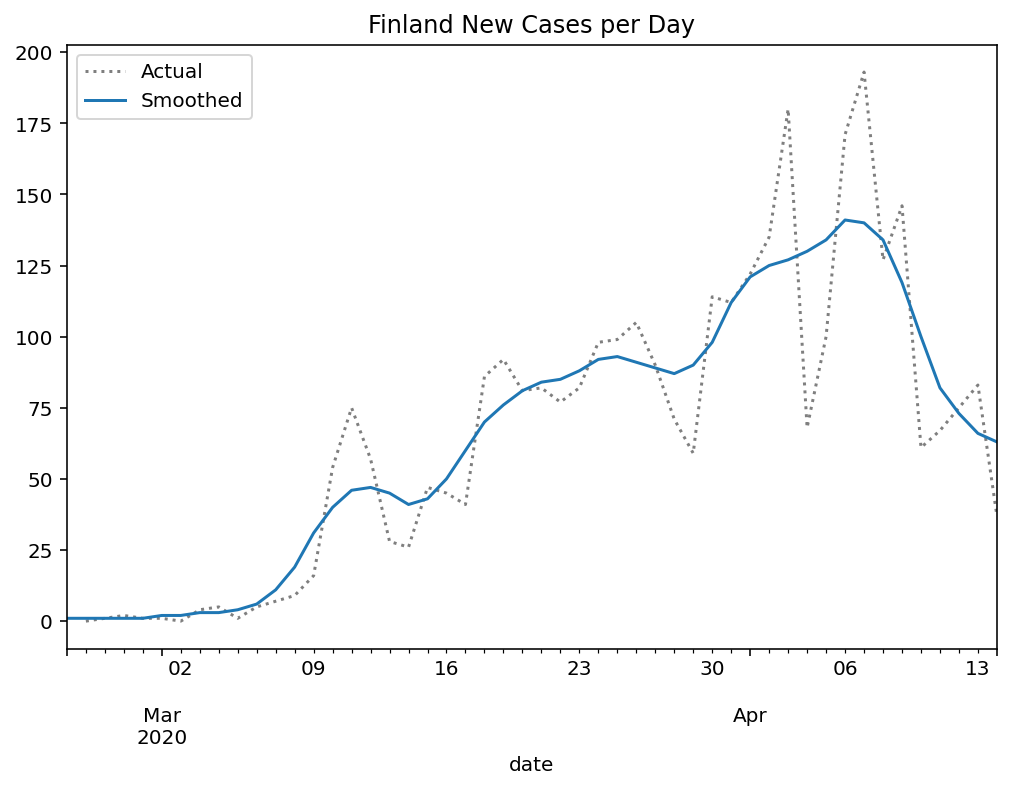

In [84]:
#state_name = 'New York'
state_name = 'Finland'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

#cases = states.xs(state_name).rename(f"{state_name} cases")
cases = finland['cases'].rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [85]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

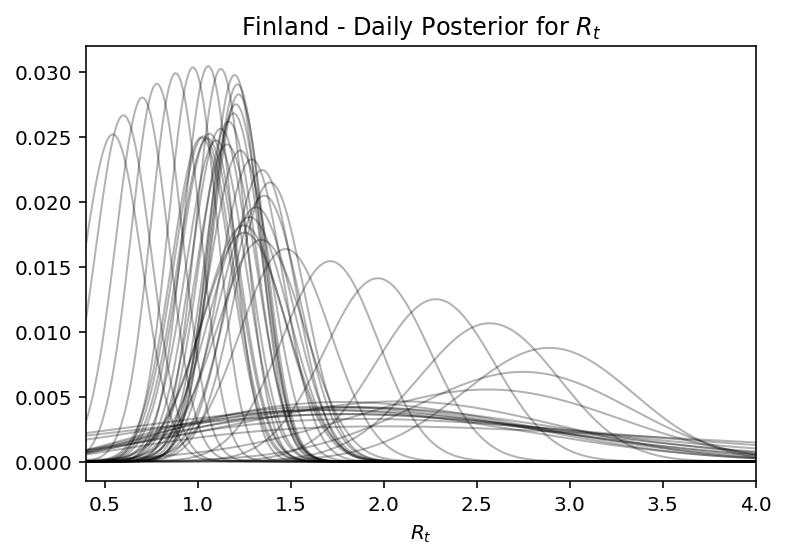

In [86]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [87]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-04-10,0.88,0.63,1.16
2020-04-11,0.78,0.51,1.05
2020-04-12,0.70,0.42,0.98
2020-04-13,0.60,0.31,0.90
2020-04-14,0.54,0.24,0.87


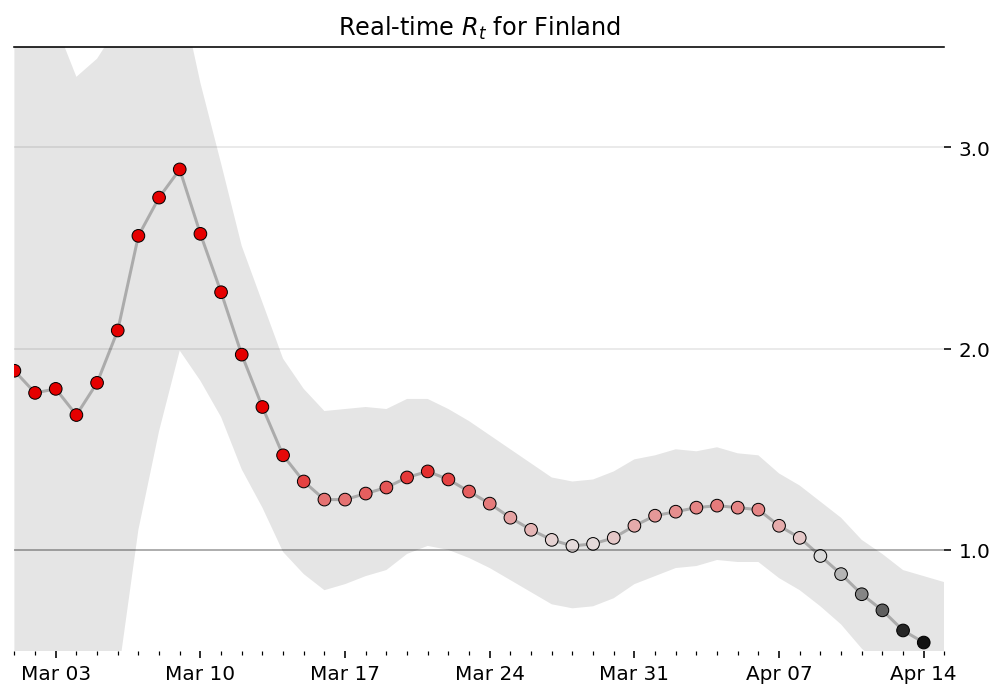

In [88]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the Process for Every State

In [89]:
results = {}

states_to_process = states.loc[~states.index.get_level_values('state').isin(FILTERED_REGIONS)]

for state_name, cases in states_to_process.groupby(level='state'):
    clear_output(wait=True)
    print(f'Processing {state_name}')
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


### Plot All US States

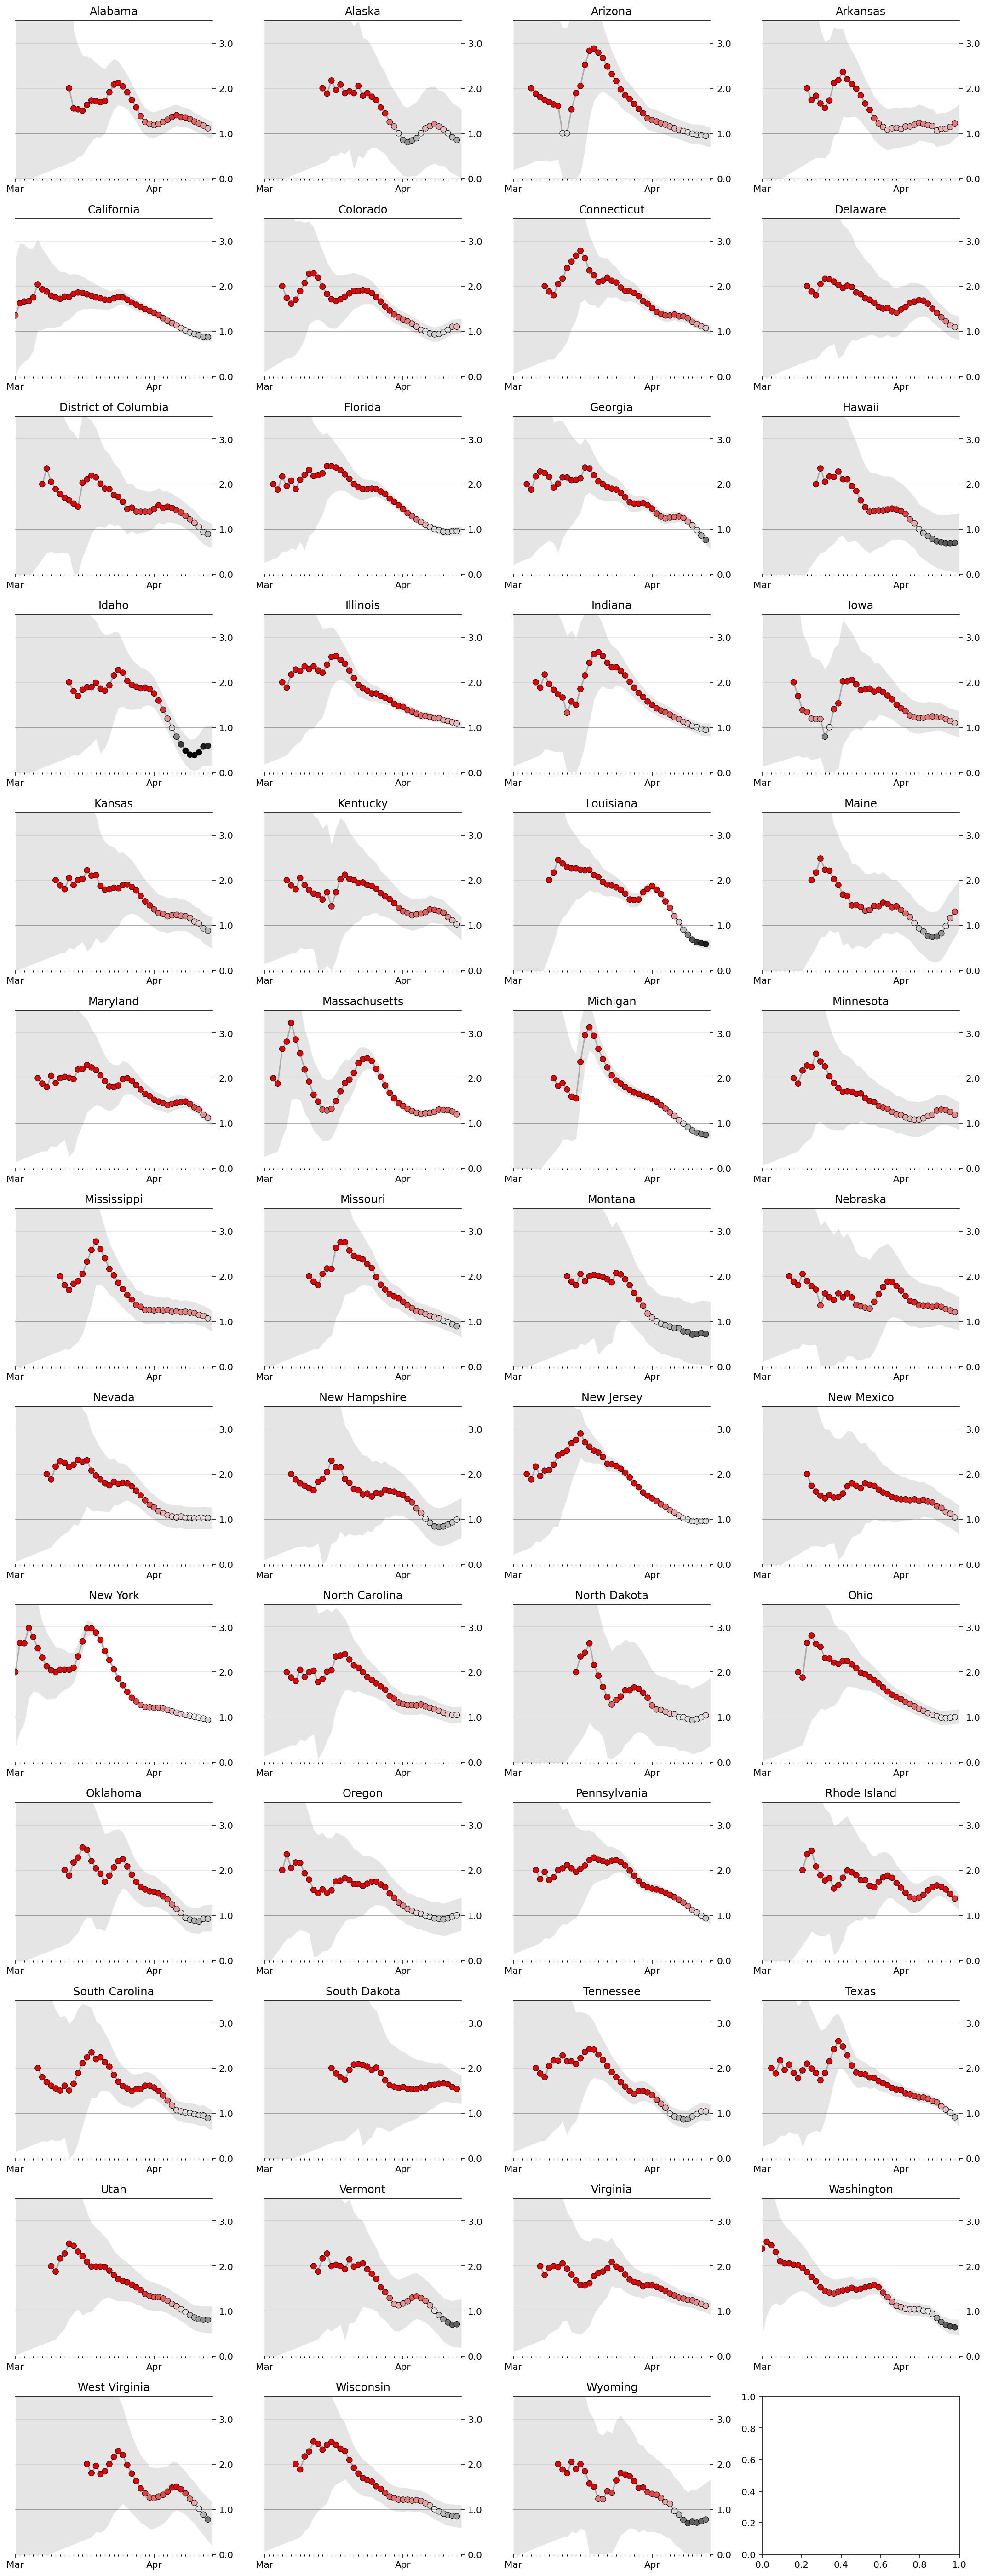

In [90]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [91]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

# Uncomment this line if you'd like to export
# overall.to_csv('data/rt.csv')

### Standings

In [92]:
# As of 4/12
no_lockdown = [
    'North Dakota',
    'South Dakota',
    'Nebraska',
    'Iowa',
    'Arkansas'
]
partial_lockdown = [
    'Utah',
    'Wyoming',
    'Oklahoma'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

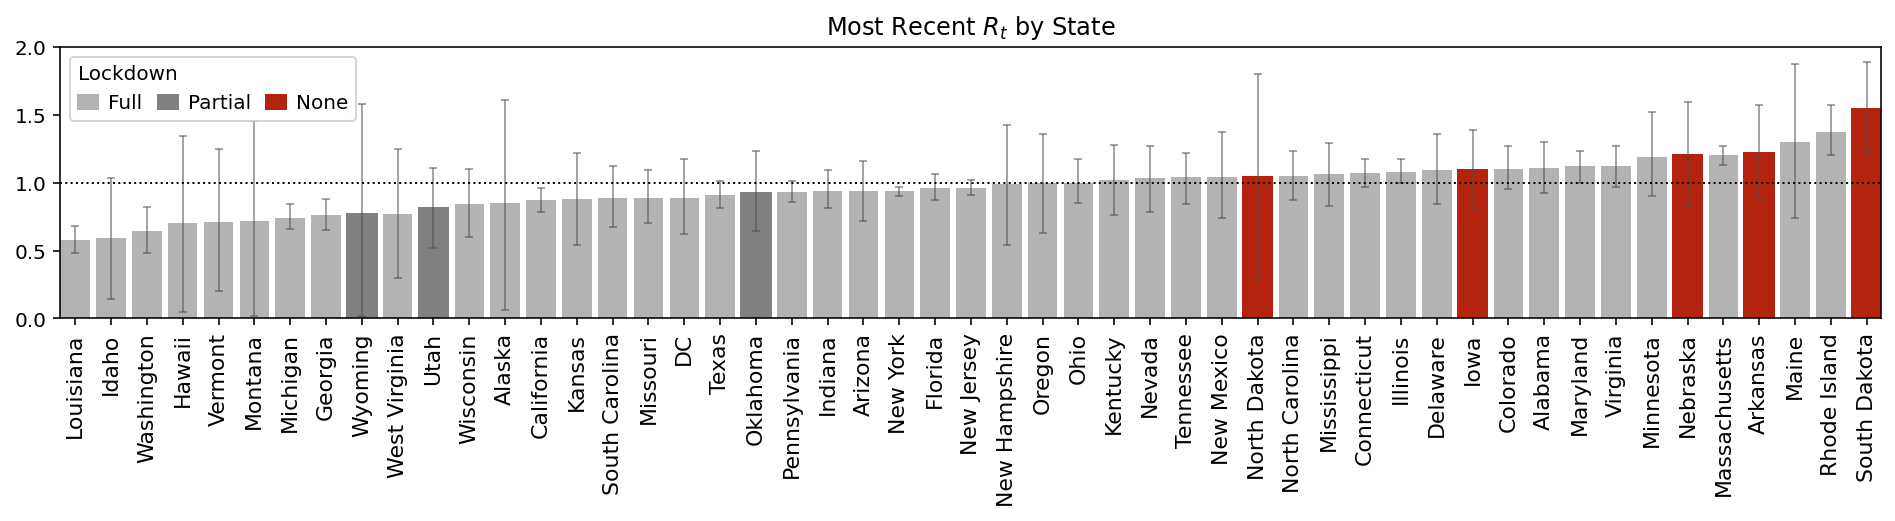

In [93]:
filtered = overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = overall.loc[~filtered].groupby(level=0)[['ML', 'High', 'Low']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

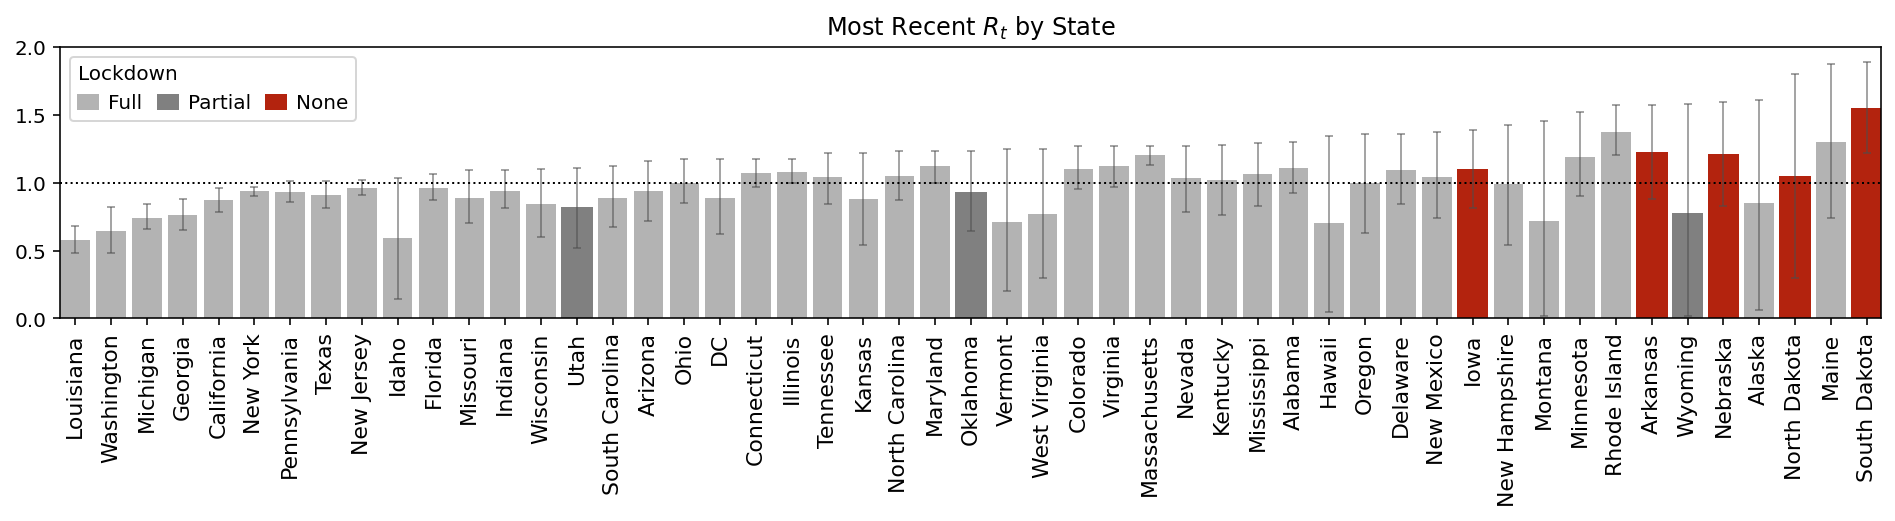

In [94]:
mr.sort_values('High', inplace=True)
plot_standings(mr);

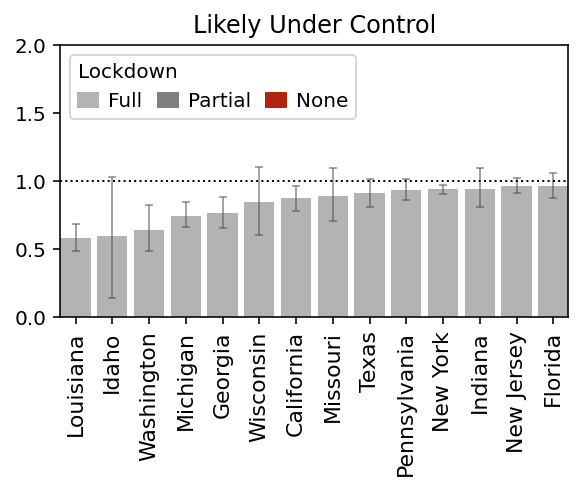

In [95]:
show = mr[mr.High.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

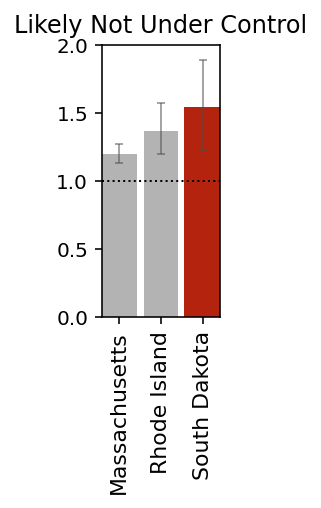

In [96]:
show = mr[mr.Low.ge(1.05)].sort_values('Low')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()